## Projektarbeit: How to avoid dying from eating poisonous mushrooms

In [1]:
import pandas as pd
import numpy as np
from sklearn import tree, metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, precision_recall_fscore_support, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
import math
import tqdm
from mpl_toolkits.mplot3d import Axes3D
import shap
from shap import Explainer
from shap.plots import beeswarm

In [2]:
# fetch dataset
m_shroom = fetch_ucirepo(id=73)

# data (as pandas dataframes)
x = m_shroom.data.features
y = m_shroom.data.targets

mushroom = pd.concat([x, y], axis=1)

# metadata
print(m_shroom.metadata)

# variable information
print(m_shroom.variables)

{'uci_id': 73, 'name': 'Mushroom', 'repository_url': 'https://archive.ics.uci.edu/dataset/73/mushroom', 'data_url': 'https://archive.ics.uci.edu/static/public/73/data.csv', 'abstract': 'From Audobon Society Field Guide; mushrooms described in terms of physical characteristics; classification: poisonous or edible', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 8124, 'num_features': 22, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['poisonous'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1981, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5959T', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': "This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family (pp. 500-525).  Each species is identified as definitely edible, definitely po

In [3]:
x.head ()

cap-shape cap-surface cap-color bruises odor gill-attachment gill-spacing  \
0         x           s         n       t    p               f            c   
1         x           s         y       t    a               f            c   
2         b           s         w       t    l               f            c   
3         x           y         w       t    p               f            c   
4         x           s         g       f    n               f            w   

  gill-size gill-color stalk-shape  ... stalk-surface-below-ring  \
0         n          k           e  ...                        s   
1         b          k           e  ...                        s   
2         b          n           e  ...                        s   
3         n          n           e  ...                        s   
4         b          k           t  ...                        s   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      w                      w         p          w   
1                      w                      w         p          w   
2                      w                      w         p          w   
3                      w                      w         p          w   
4                      w                      w         p          w   

  ring-number ring-type spore-print-color population habitat  
0           o         p                 k          s       u  
1           o         p                 n          n       g  
2           o         p                 n          n       m  
3           o         p                 k          s       u  
4           o         e                 n          a       g  

[5 rows x 22 columns]

In [4]:
y.head ()

poisonous
0         p
1         e
2         e
3         p
4         e

In [5]:
# Split data for testing and training
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=None)

print('Train set shape: {}'.format(x_train.shape))
print('Test set shape: {}'.format(x_test.shape))

Train set shape: (5443, 22)
Test set shape: (2681, 22)


In [6]:
# Imputing missing values with pandas dataframe
si = SimpleImputer(strategy='most_frequent')
x_train = si.fit_transform(x_train)
x_test = si.transform(x_test)

x_train = pd.DataFrame(x_train,columns=m_shroom.data.features.columns)
x_test = pd.DataFrame(x_test,columns=m_shroom.data.features.columns)

In [7]:
# no missing target-values

In [8]:
# Rename the column to "target"
y_train.rename(columns={"poisonous": "target"}, inplace=True)
y_test.rename(columns={"poisonous": "target"}, inplace=True)

# Encoding of the target
y_train['target'] = y_train['target'].map({'p': 1, 'e': 0})
y_test['target'] = y_test['target'].map({'p': 1, 'e': 0})

In [10]:
# Label-Encoding of x-values
label_encoders = {}
for column in x_train.columns:
    encoder = LabelEncoder()
    x_train[column] = encoder.fit_transform(x_train[column])
    x_test[column] = encoder.transform(x_test[column])

    # Store the encoder to handle new data or inverse transformation if needed
    label_encoders[column] = encoder

In [10]:
# One-Hot-Encoding of x-values
# encoder = OneHotEncoder(drop="first")
#encoder.fit(x_train)
#x_encoded = encoder.transform(x_train)
#x_train = pd.DataFrame(x_encoded.todense(),columns=encoder.get_feature_names_out())

#encoder.fit(x_test)
#x_encoded2 = encoder.transform(x_test)
#x_test = pd.DataFrame(x_encoded2.todense(),columns=encoder.get_feature_names_out())

In [11]:
# Normalizing x-values
scaler = MinMaxScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Convert the numpy arrays to DataFrames
x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train.columns)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=x_test.columns)

x_train = x_train_scaled
x_test = x_test_scaled

In [12]:
# Multicollinearity

# Reset indices of x_train and y_train
x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

# Concatenate x_train and y_train into mushroom_train DataFrame
mushroom_train = pd.concat([x_train, y_train], axis=1)

corr_matrix = mushroom_train.corr().abs()
corr_matrix

cap-shape  cap-surface  cap-color   bruises  \
cap-shape                  1.000000     0.046497   0.046945  0.024139   
cap-surface                0.046497     1.000000   0.015956  0.062875   
cap-color                  0.046945     0.015956   1.000000  0.007407   
bruises                    0.024139     0.062875   0.007407  1.000000   
odor                       0.034182     0.031975   0.385976  0.064517   
gill-attachment            0.089617     0.030249   0.039484  0.132907   
gill-spacing               0.004476     0.286656   0.155581  0.305247   
gill-size                  0.052437     0.202043   0.170866  0.384427   
gill-color                 0.012037     0.154845   0.082318  0.530561   
stalk-shape                0.064000     0.032112   0.458611  0.097146   
stalk-root                 0.006371     0.030609   0.274422  0.054659   
stalk-surface-above-ring   0.028732     0.079027   0.068216  0.454690   
stalk-surface-below-ring   0.028005     0.101927   0.047173  0.459893   
stalk-color-above-ring     0.036544     0.067372   0.011830  0.073606   
stalk-color-below-ring     0.039680     0.063172   0.018291  0.084748   
veil-type                       NaN          NaN        NaN       NaN   
veil-color                 0.083354     0.014034   0.036098  0.115917   
ring-number                0.125137     0.022666   0.002999  0.059039   
ring-type                  0.021490     0.105674   0.162240  0.695162   
spore-print-color          0.087985     0.220316   0.284842  0.287313   
population                 0.069227     0.029023   0.158267  0.083146   
habitat                    0.026797     0.163932   0.031389  0.076034   
target                     0.055794     0.187712   0.040374  0.507020   

                              odor  gill-attachment  gill-spacing  gill-size  \
cap-shape                 0.034182         0.089617      0.004476   0.052437   
cap-surface               0.031975         0.030249      0.286656   0.202043   
cap-color                 0.385976         0.039484      0.155581   0.170866   
bruises                   0.064517         0.132907      0.305247   0.384427   
odor                      1.000000         0.058740      0.067466   0.304908   
gill-attachment           0.058740         1.000000      0.068508   0.104068   
gill-spacing              0.067466         0.068508      1.000000   0.109246   
gill-size                 0.304908         0.104068      0.109246   1.000000   
gill-color                0.123922         0.126658      0.096481   0.518213   
stalk-shape               0.462056         0.180603      0.076249   0.217997   
stalk-root                0.038411         0.064427      0.416760   0.117709   
stalk-surface-above-ring  0.119751         0.086621      0.212300   0.057214   
stalk-surface-below-ring  0.056646         0.109733      0.215963   0.005040   
stalk-color-above-ring    0.169399         0.093309      0.273499   0.295371   
stalk-color-below-ring    0.161601         0.090781      0.254904   0.274190   
veil-type                      NaN              NaN           NaN        NaN   
veil-color                0.056226         0.902459      0.072335   0.100793   
ring-number               0.115555         0.085556      0.239755   0.176182   
ring-type                 0.283436         0.141366      0.194936   0.469818   
spore-print-color         0.467367         0.004618      0.047663   0.630607   
population                0.035937         0.161666      0.523698   0.146853   
habitat                   0.024674         0.032047      0.152241   0.155582   
target                    0.097440         0.126334      0.345094   0.544347   

                          gill-color  stalk-shape  ...  \
cap-shape                   0.012037     0.064000  ...   
cap-surface                 0.154845     0.032112  ...   
cap-color                   0.082318     0.458611  ...   
bruises                     0.530561     0.097146  ...   
odor                        0.123922     0.462056  ...   
gill

In [13]:
# Filter out correlations where both features are the same (correlation equals 1)
mask = np.eye(len(corr_matrix), dtype=bool)
filtered_corr = corr_matrix.mask(mask)

# Find correlations greater than or equal to 0.5
high_corr = filtered_corr[filtered_corr >= 0.5].stack().reset_index()

high_corr.head (20)

level_0            level_1         0
0             bruises         gill-color  0.530561
1             bruises          ring-type  0.695162
2             bruises             target  0.507020
3     gill-attachment         veil-color  0.902459
4        gill-spacing         population  0.523698
5           gill-size         gill-color  0.518213
6           gill-size  spore-print-color  0.630607
7           gill-size             target  0.544347
8          gill-color            bruises  0.530561
9          gill-color          gill-size  0.518213
10         gill-color          ring-type  0.633635
11         gill-color             target  0.535567
12         veil-color    gill-attachment  0.902459
13          ring-type            bruises  0.695162
14          ring-type         gill-color  0.633635
15  spore-print-color          gill-size  0.630607
16         population       gill-spacing  0.523698
17             target            bruises  0.507020
18             target          gill-size  0.544347
19             target         gill-color  0.535567

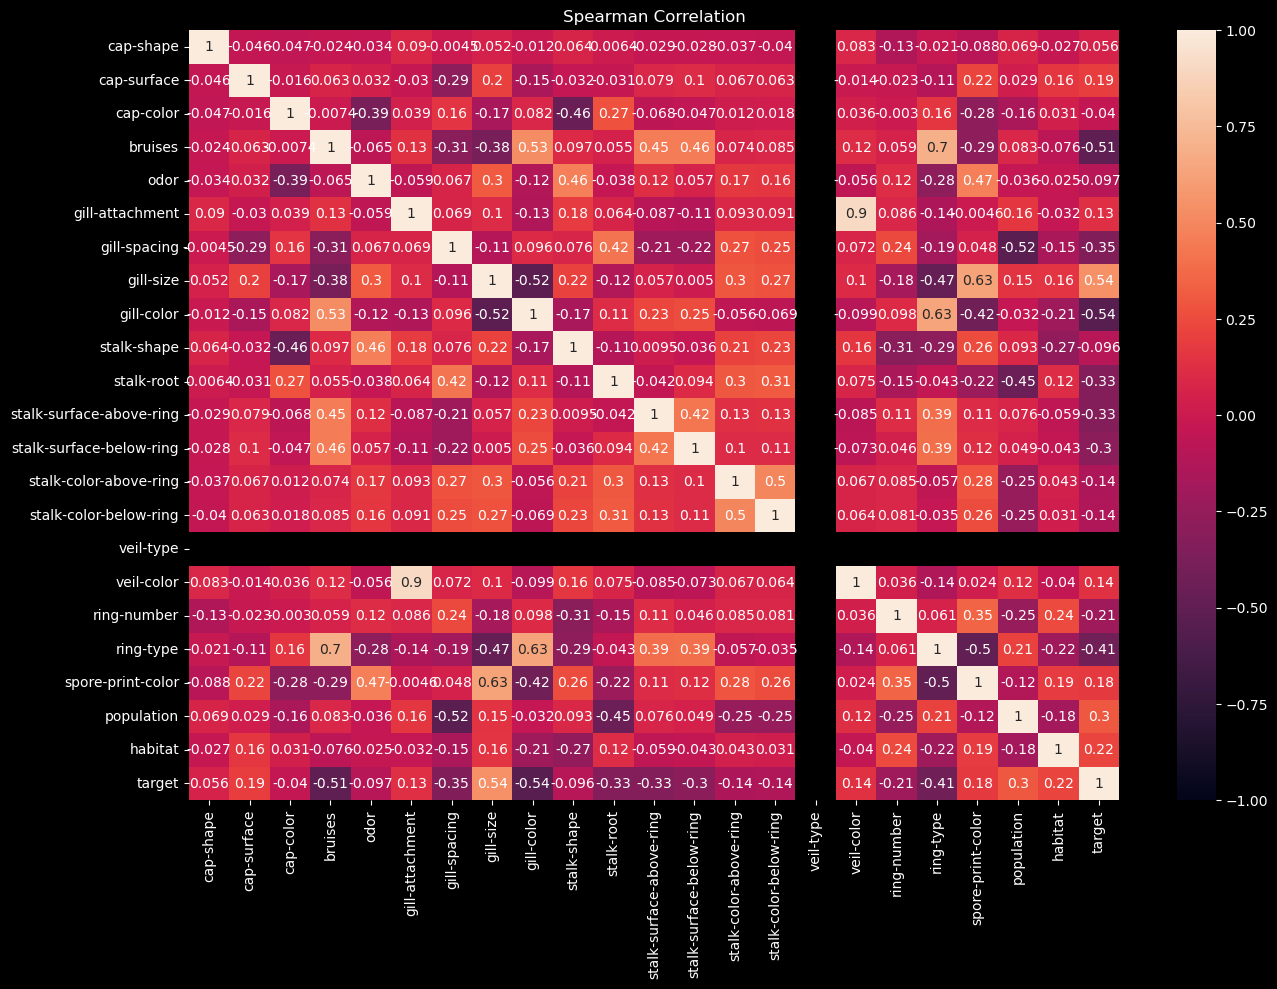

In [14]:
# Visualization of correlations with Spearman
import seaborn as sns

def display_correlation(mushroom_train):
    r = mushroom_train.corr(method="spearman")
    plt.figure(figsize=(15,10))
    heatmap = sns.heatmap(mushroom_train.corr(), vmin=-1, vmax=1, annot=True)
    plt.title("Spearman Correlation")
    return(r)

r_simple = display_correlation(mushroom_train)

## Machine Learning Models

### KNeirestNeighbors

In [16]:
# Building a Model: KNeirestneighbors
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)

/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

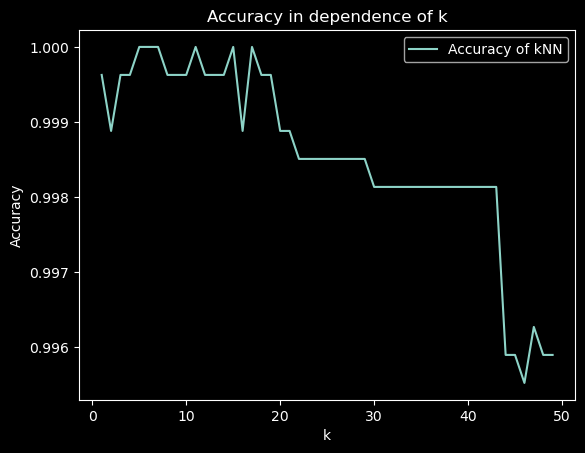

In [19]:
# Ensure x_train and y_train are NumPy arrays
x_train = x_train.values if isinstance(x_train, pd.DataFrame) else x_train
x_test = x_test.values if isinstance(x_test, pd.DataFrame) else x_test
y_train = y_train.values if isinstance(y_train, pd.DataFrame) else y_train
y_test = y_test.values if isinstance(y_test, pd.DataFrame) else y_test

# Ensure y_train is a 1D array
if y_train.ndim > 1:
    y_train = y_train.squeeze()

# Finding the best k
scores = []
for i in range(1, 50):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train, y_train)
    scores.append(knn.score(x_test, y_test))

plt.title("Accuracy in dependence of k")
plt.plot(range(1, 50), scores, label="Accuracy of kNN")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

<class 'pandas.core.frame.DataFrame'>
(5443, 22)
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
True
<class 'pandas.core.frame.DataFrame'>
(1, 22)


  0%|          | 0/5443 [00:00<?, ?it/s]

Background samples shape: (1, 22)
SHAP values shape: (5443, 22)


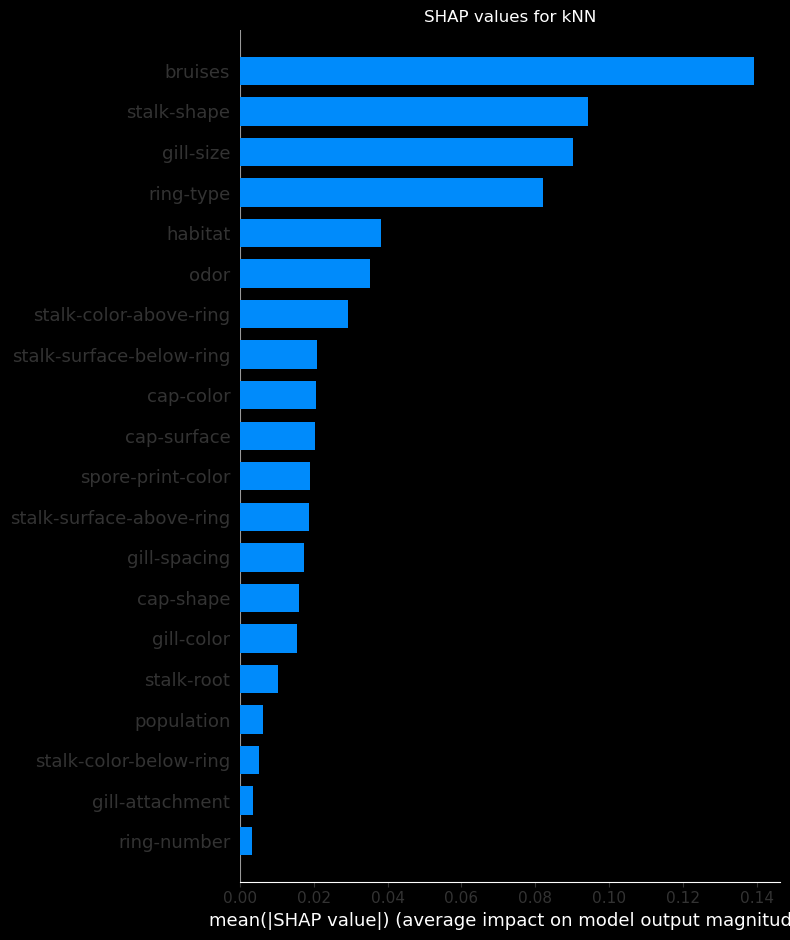

In [14]:
print(type(x_train))
print(x_train.shape)

print(type(knn))
print(hasattr(knn, 'predict'))

# Summarize background data using shap.sample
background_samples = shap.sample(x_train, 1)
print(type(background_samples))
print(background_samples.shape)

# SHAP Interpretation
explainer_knn = shap.KernelExplainer(knn.predict, background_samples)
shap_values_knn = explainer_knn.shap_values(x_train)

# Ensure the shapes are as expected
print(f"Background samples shape: {background_samples.shape}")
print(f"SHAP values shape: {np.array(shap_values_knn).shape}")

plt.figure(figsize=(8, 8))
plt.title("SHAP values for kNN")
shap.summary_plot(shap_values_knn, x_train, plot_type="bar")
plt.show()

In [17]:
# calculate accuracy, precision and recall for knn
predict_knn = knn.predict(x_test)

cm = confusion_matrix(predict_knn, y_test)
_, fp, fn, tp = cm.ravel()

print("accuracy for knn: {}".format(accuracy_score(predict_knn, y_test)))
print("precision for knn: {}".format(tp/(tp + fp)))
print("recall for knn: {}".format(tp/(tp + fn)))

accuracy for knn: 1.0
precision for knn: 1.0
recall for knn: 1.0


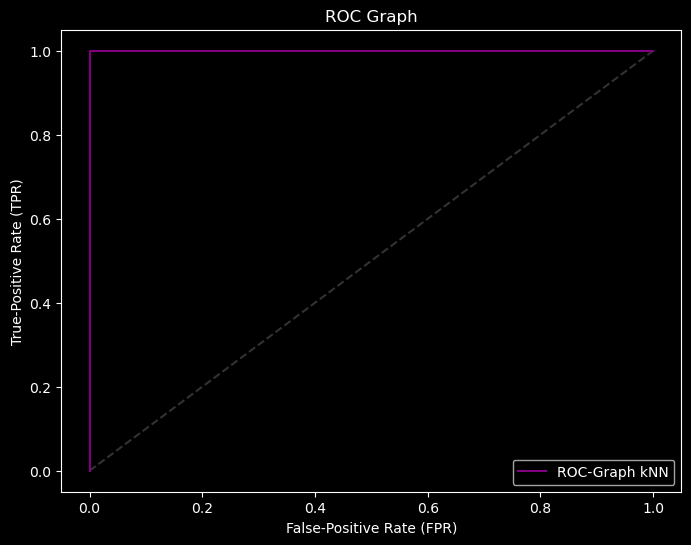

In [18]:
# Graphing the ROC-Graph
plt.figure(figsize=(8,6))
plt.title("ROC Graph")
fpr, tpr, thresholds = metrics.roc_curve(y_test.values, knn.predict_proba(x_test)[:,1:])
plt.plot([0,1],[0,1],ls="--",c="white",alpha=0.2)
plt.plot(fpr,tpr,label="ROC-Graph kNN",c="purple")
plt.xlabel("False-Positive Rate (FPR)")
plt.ylabel("True-Positive Rate (TPR)")
plt.legend()
plt.show()

### Decision Tree

In [19]:
# Building a Model: Decision Tree
dtc = DecisionTreeClassifier(max_depth=4, min_samples_split=50, class_weight = "balanced", random_state=1)
dtc.fit(x_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                       min_samples_split=50, random_state=1)

In [ ]:
# optimizing hyperparameters


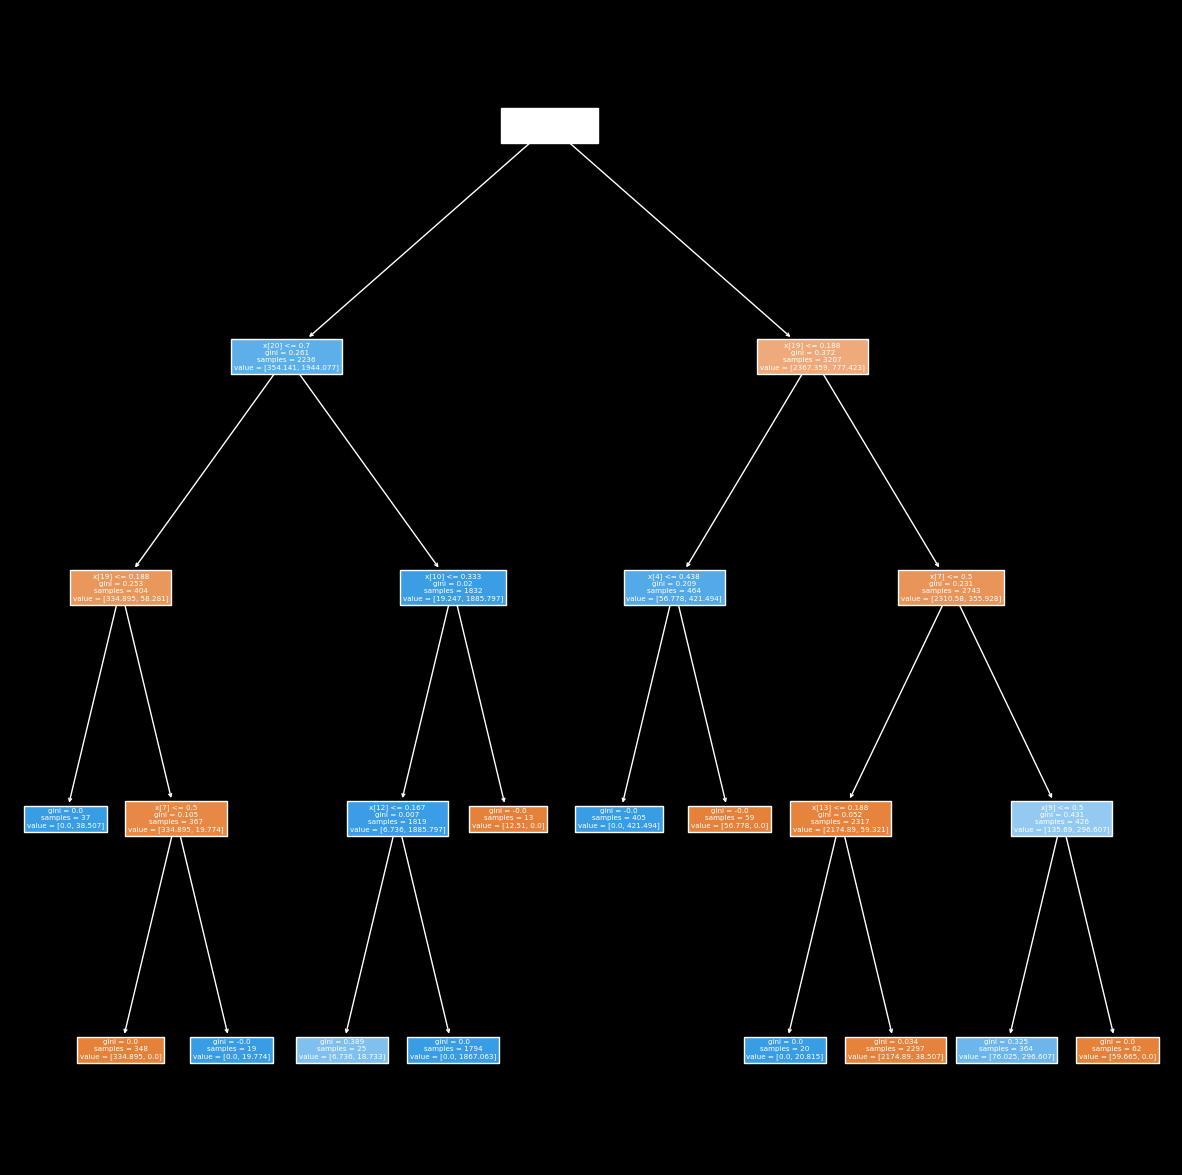

In [20]:
fig = plt.figure(figsize=(15,15))
baum = tree.plot_tree(dtc, filled=True)

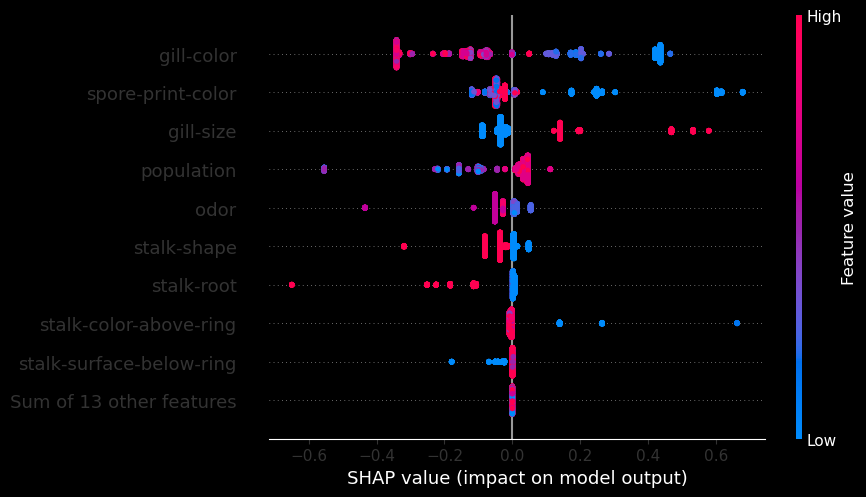

In [20]:
# calculate feature importance with SHAP
explainer_short_dtc= shap.Explainer(dtc)
sv_dtc= explainer_short_dtc(x_train)

shap.plots.beeswarm(sv_dtc[:, :, 1])

<class 'pandas.core.frame.DataFrame'>
(5443, 22)
<class 'sklearn.tree._classes.DecisionTreeClassifier'>
True
<class 'pandas.core.frame.DataFrame'>
(1, 22)


  0%|          | 0/5443 [00:00<?, ?it/s]

/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:2306: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:2307: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:2306: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:2307: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:2306: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_

Background samples shape: (1, 22)
SHAP values shape: (5443, 22)


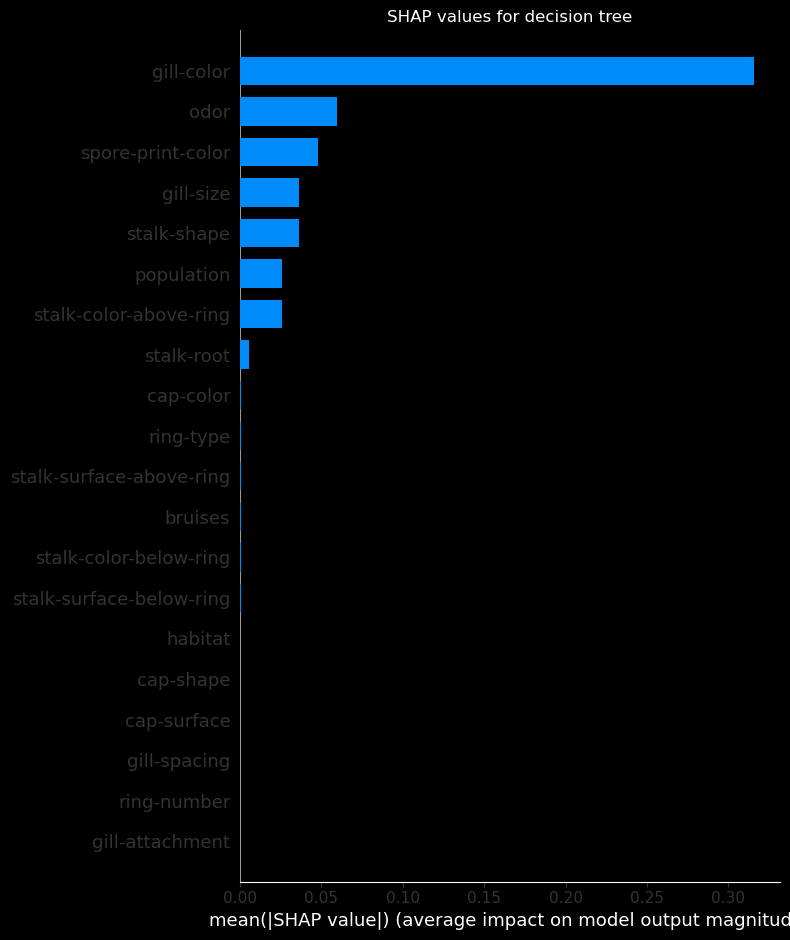

In [21]:
print(type(x_train))
print(x_train.shape)

print(type(dtc))
print(hasattr(dtc, 'predict'))

# Summarize background data using shap.sample
background_samples = shap.sample(x_train, 1)
print(type(background_samples))
print(background_samples.shape)

# SHAP Interpretation
explainer_dtc = shap.KernelExplainer(dtc.predict, background_samples)
shap_values_dtc = explainer_dtc.shap_values(x_train)

# Ensure the shapes are as expected
print(f"Background samples shape: {background_samples.shape}")
print(f"SHAP values shape: {np.array(shap_values_dtc).shape}")

plt.figure(figsize=(8, 8))
plt.title("SHAP values for decision tree")
shap.summary_plot(shap_values_dtc, x_train, plot_type="bar")
plt.show()

In [22]:
# calculate accuracy, precision and recall for dtc
predict_dtc = dtc.predict(x_test)

cm = confusion_matrix(predict_dtc, y_test)
_, fp, fn, tp = cm.ravel()

print("accuracy for Decision Tree: {}".format(accuracy_score(predict_dtc, y_test)))
print("precision for Decision Tree: {}".format(tp/(tp + fp)))
print("recall for Decision Tree: {}".format(tp/(tp + fn)))

accuracy for Decision Tree: 0.9787392763894069
precision for Decision Tree: 0.9915449654112222
recall for Decision Tree: 0.9655688622754491


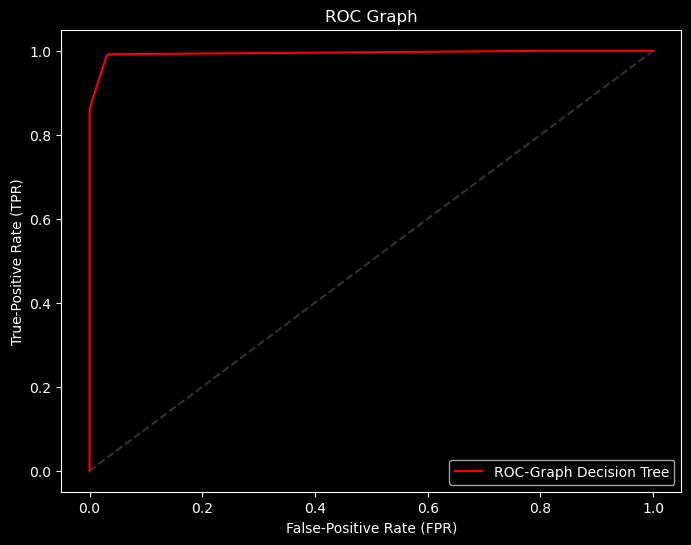

In [23]:
# Graphing the ROC-Graph
plt.figure(figsize=(8,6))
plt.title("ROC Graph")
fpr, tpr, thresholds = metrics.roc_curve(y_test.values, dtc.predict_proba(x_test)[:,1:])
plt.plot([0,1],[0,1],ls="--",c="white",alpha=0.2)
plt.plot(fpr,tpr,label="ROC-Graph Decision Tree",c="red")
plt.xlabel("False-Positive Rate (FPR)")
plt.ylabel("True-Positive Rate (TPR)")
plt.legend()
plt.show()

### Logistic Regression

In [33]:
# Building a model: Logistic Regression
logreg = LogisticRegression(solver='liblinear', penalty='l1', max_iter=100, l1_ratio=0.84, C=719.69)
logreg.fit(x_train, y_train)

/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=719.69, l1_ratio=0.84, penalty='l1', solver='liblinear')

In [26]:
# Optimizing Hyperparameters with Random Search
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': np.logspace(-4, 4, 50),
    'solver': ['lbfgs', 'saga', 'liblinear', 'newton-cg'],
    'max_iter': [100, 200, 300],
    'l1_ratio': np.linspace(0, 1, 20)  # Only used if penalty is 'elasticnet'
}

random_search = RandomizedSearchCV(estimator=logreg, param_distributions=param_dist,scoring='accuracy', n_iter=100, cv=3, verbose=1, n_jobs=-1, random_state=42)
random_search.fit(x_train_scaled, y_train.values.ravel())

print(random_search.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and wi

{'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 100, 'l1_ratio': 0.8421052631578947, 'C': 719.6856730011514}


/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


<class 'pandas.core.frame.DataFrame'>
(5443, 22)
<class 'sklearn.linear_model._logistic.LogisticRegression'>
True
<class 'pandas.core.frame.DataFrame'>
(1, 22)


  0%|          | 0/5443 [00:00<?, ?it/s]

Background samples shape: (1, 22)
SHAP values shape: (5443, 22)


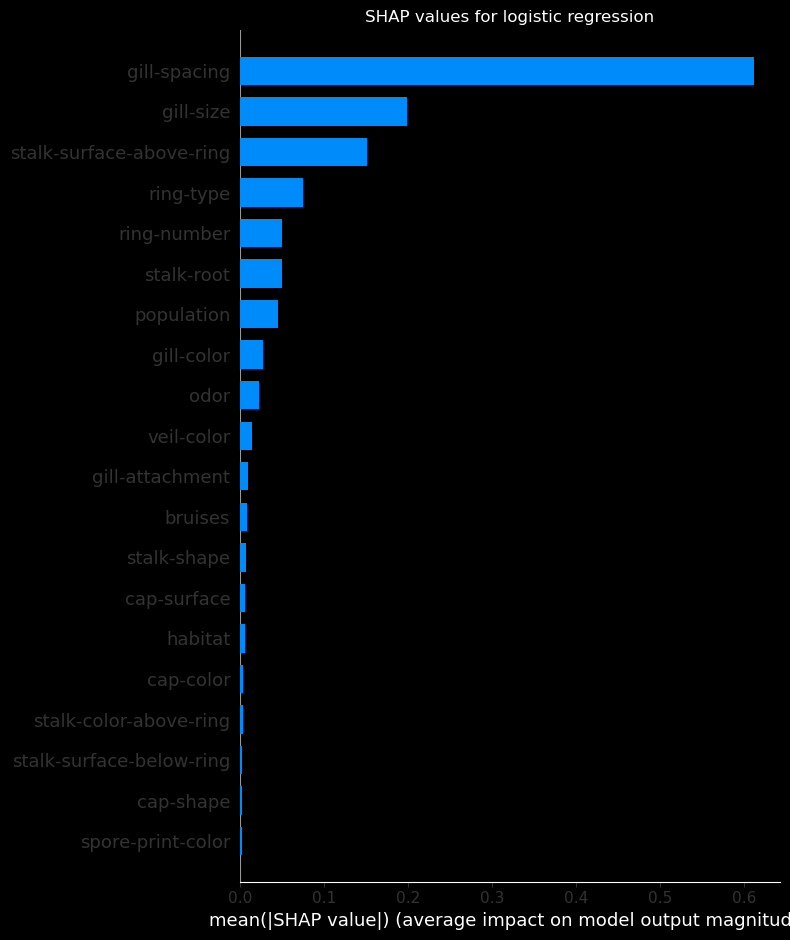

In [52]:
# Analyzing SHAP-value
print(type(x_train))
print(x_train.shape)

print(type(logreg))
print(hasattr(logreg, 'predict'))

# Summarize background data using shap.sample
background_samples = shap.sample(x_train, 1)
print(type(background_samples))
print(background_samples.shape)

# SHAP Interpretation
explainer_logreg = shap.KernelExplainer(logreg.predict, background_samples)
shap_values_logreg = explainer_logreg.shap_values(x_train)

# Ensure the shapes are as expected
print(f"Background samples shape: {background_samples.shape}")
print(f"SHAP values shape: {np.array(shap_values_logreg).shape}")

plt.figure(figsize=(8, 8))
plt.title("SHAP values for logistic regression")
shap.summary_plot(shap_values_logreg, x_train, plot_type="bar")
plt.show()

In [34]:
# calculate accuracy, precision and recall for logistic regression
predict_logreg = logreg.predict(x_test)

cm = confusion_matrix(predict_logreg, y_test)
_, fp, fn, tp = cm.ravel()

print("accuracy for Logistic Regression: {}".format(accuracy_score(predict_logreg, y_test)))
print("precision for Logistic Regression: {}".format(tp/(tp + fp)))
print("recall for Logistic Regression: {}".format(tp/(tp + fn)))

accuracy for Logistic Regression: 0.9653114509511377
precision for Logistic Regression: 0.9723289777094543
recall for Logistic Regression: 0.9568835098335855


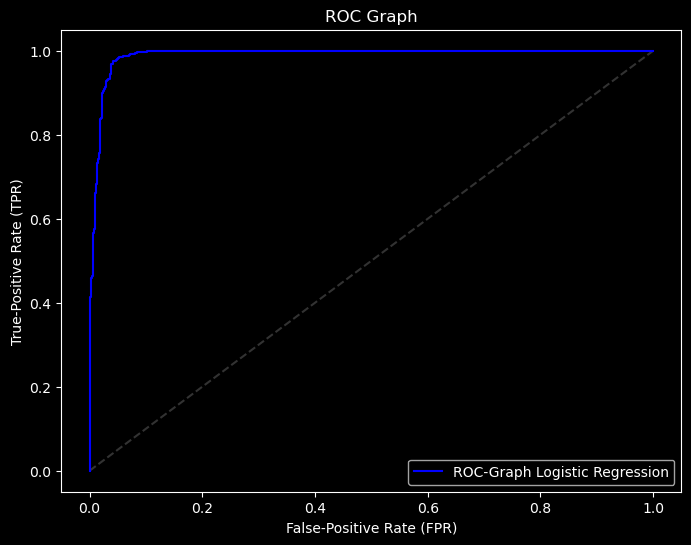

In [36]:
# Graphing the ROC-Graph
plt.figure(figsize=(8,6))
plt.title("ROC Graph")
fpr, tpr, thresholds = metrics.roc_curve(y_test.values, logreg.predict_proba(x_test)[:,1:])
plt.plot([0,1],[0,1],ls="--",c="white",alpha=0.2)
plt.plot(fpr,tpr,label="ROC-Graph Logistic Regression",c="blue")
plt.xlabel("False-Positive Rate (FPR)")
plt.ylabel("True-Positive Rate (TPR)")
plt.legend()
plt.show()

### Support Vector Machine Classifier

In [39]:
# Building a model: Support Vector Machine
svm = SVC(probability=True)
svm.fit(x_train, y_train)

/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(probability=True)

In [ ]:
# opimizing hyperparameters


<class 'pandas.core.frame.DataFrame'>
(5443, 22)
<class 'sklearn.svm._classes.SVC'>
True
<class 'pandas.core.frame.DataFrame'>
(1, 22)


  0%|          | 0/5443 [00:00<?, ?it/s]

Background samples shape: (1, 22)
SHAP values shape: (5443, 22)


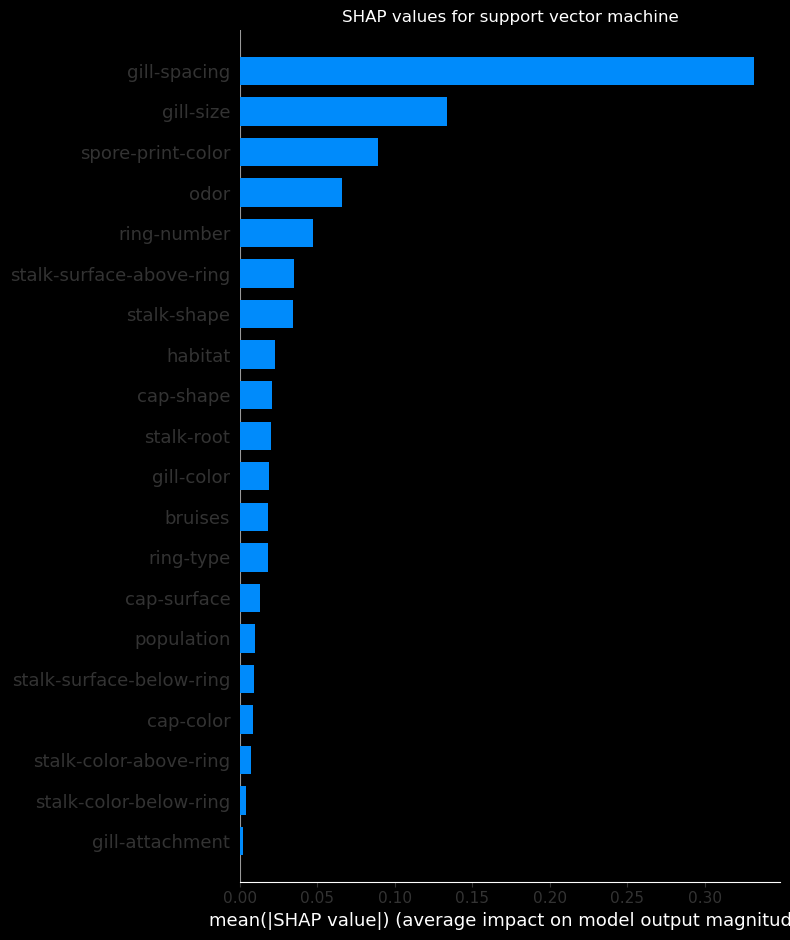

In [53]:
# SHAP
print(type(x_train))
print(x_train.shape)

print(type(svm))
print(hasattr(svm, 'predict'))

# Summarize background data using shap.sample
background_samples = shap.sample(x_train, 1)
print(type(background_samples))
print(background_samples.shape)

# SHAP Interpretation
explainer_svm = shap.KernelExplainer(svm.predict, background_samples)
shap_values_svm = explainer_svm.shap_values(x_train)

# Ensure the shapes are as expected
print(f"Background samples shape: {background_samples.shape}")
print(f"SHAP values shape: {np.array(shap_values_svm).shape}")

plt.figure(figsize=(8, 8))
plt.title("SHAP values for support vector machine")
shap.summary_plot(shap_values_svm, x_train, plot_type="bar")
plt.show()

In [40]:
# calculate accuracy, precision and recall for support vector machine
predict_svm = svm.predict(x_test)

cm = confusion_matrix(predict_svm, y_test)
_, fp, fn, tp = cm.ravel()
print("accuracy of support vector machine: {}".format(accuracy_score(predict_svm, y_test)))
print("precision of support vectir machine: {}".format(tp/(tp + fp)))
print("recall of support vector machine: {}".format(tp/(tp + fn)))

accuracy of support vector machine: 0.9985080193957478
precision of support vectir machine: 1.0
recall of support vector machine: 0.9969348659003832


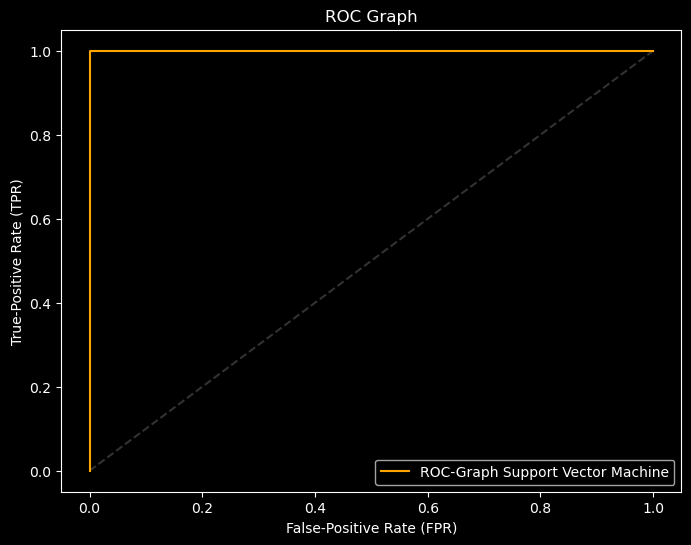

In [41]:
# Graphing the ROC-Graph
plt.figure(figsize=(8,6))
plt.title("ROC Graph")
fpr, tpr, thresholds = metrics.roc_curve(y_test.values, svm.predict_proba(x_test)[:,1:])
plt.plot([0,1],[0,1],ls="--",c="white",alpha=0.2)
plt.plot(fpr,tpr,label="ROC-Graph Support Vector Machine",c="orange")
plt.xlabel("False-Positive Rate (FPR)")
plt.ylabel("True-Positive Rate (TPR)")
plt.legend()
plt.show()

### Random Forest

In [42]:
# Building a Model: Random Forest
random = RandomForestClassifier (criterion="entropy", max_depth=4, min_samples_split=50, random_state=1)
random.fit(x_train, y_train)

/var/folders/_s/1t0lm39d5b1bl47vd_q5jfth0000gn/T/ipykernel_1101/3907041798.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random.fit(x_train, y_train)


RandomForestClassifier(criterion='entropy', max_depth=4, min_samples_split=50,
                       random_state=1)

In [ ]:
# optimizing hyperparameters

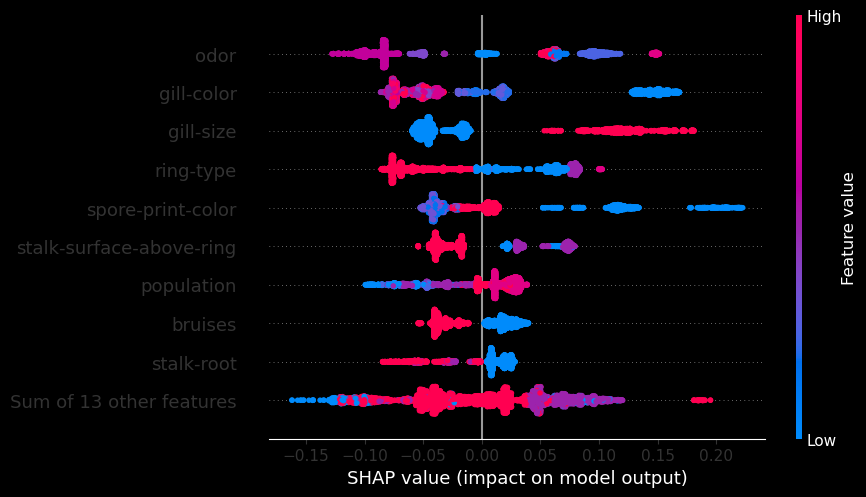

In [33]:
# calculate feature importance with SHAP
explainer_short_random = shap.Explainer(random)
sv_random = explainer_short_random(x_train)

shap.plots.beeswarm(sv_random[:, :, 1])

<class 'pandas.core.frame.DataFrame'>
(5443, 22)
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
True
<class 'pandas.core.frame.DataFrame'>
(1, 22)


  0%|          | 0/5443 [00:00<?, ?it/s]

/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:2306: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:2307: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:2306: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:2307: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:2306: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_

Background samples shape: (1, 22)
SHAP values shape: (5443, 22)


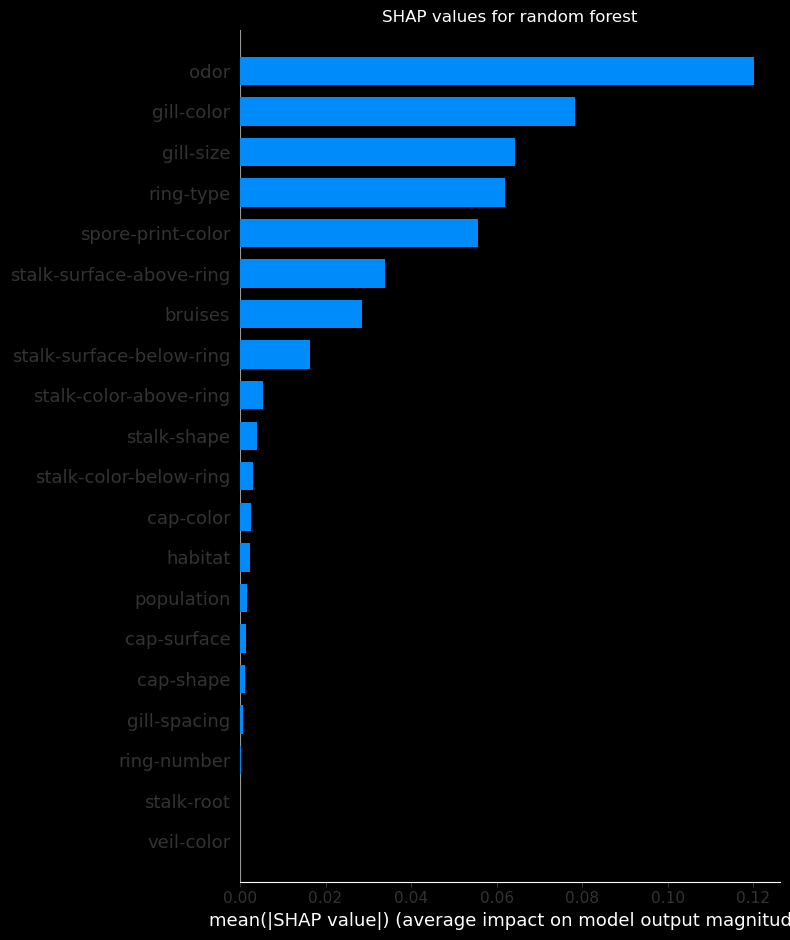

In [34]:
# Analyzing SHAP-value
print(type(x_train))
print(x_train.shape)

print(type(random))
print(hasattr(random, 'predict'))

# Summarize background data using shap.sample
background_samples = shap.sample(x_train, 1)
print(type(background_samples))
print(background_samples.shape)

# SHAP Interpretation
explainer_random = shap.KernelExplainer(random.predict, background_samples)
shap_values_random = explainer_random.shap_values(x_train)

# Ensure the shapes are as expected
print(f"Background samples shape: {background_samples.shape}")
print(f"SHAP values shape: {np.array(shap_values_random).shape}")

plt.figure(figsize=(8, 8))
plt.title("SHAP values for random forest")
shap.summary_plot(shap_values_random, x_train, plot_type="bar")
plt.show()

In [43]:
# calculate accuracy, precision and recall for random forest
predict_random = random.predict(x_test)

cm = confusion_matrix(predict_random, y_test)
_, fp, fn, tp = cm.ravel()

print("accuracy of random forest: {}".format(accuracy_score(predict_random, y_test)))
print("precision of random forest: {}".format(tp/(tp + fp)))
print("recall of random forest: {}".format(tp/(tp + fn)))

accuracy of random forest: 0.9910481163744871
precision of random forest: 0.9815526518063028
recall of random forest: 1.0


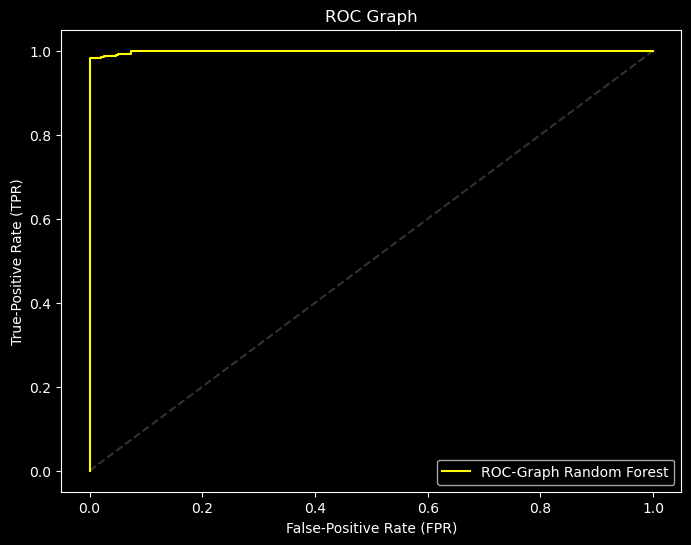

In [44]:
# Graphing the ROC-Graph
plt.figure(figsize=(8,6))
plt.title("ROC Graph")
fpr, tpr, thresholds = metrics.roc_curve(y_test.values, random.predict_proba(x_test)[:,1:])
plt.plot([0,1],[0,1],ls="--",c="white",alpha=0.2)
plt.plot(fpr,tpr,label="ROC-Graph Random Forest",c="yellow")
plt.xlabel("False-Positive Rate (FPR)")
plt.ylabel("True-Positive Rate (TPR)")
plt.legend()
plt.show()

### XG Boosting 

In [45]:
# Build a Model: XGBoost
bst = XGBClassifier(subsample=0.6, reg_lambda=0, reg_alpha=0, n_estimators=100, min_child_weight=1, max_depth=6, learning_rate=0.1, gamma=0.1, colsample_bytree=0.6, objective='binary:logistic')
bst.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Optimizing Hyperparameters with Random Search
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'min_child_weight': [1, 2, 3, 4, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1]
}

random_search = RandomizedSearchCV(estimator=bst, param_distributions=param_dist, scoring='accuracy', n_iter=100, cv=3, verbose=1, n_jobs=-1)
random_search.fit(x_train, y_train)

print(random_search.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'subsample': 0.6, 'reg_lambda': 0, 'reg_alpha': 0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.6}


<class 'pandas.core.frame.DataFrame'>
(5443, 22)
<class 'xgboost.sklearn.XGBClassifier'>
True
<class 'pandas.core.frame.DataFrame'>
(100, 22)
Background samples shape: (100, 22)
SHAP values shape: (5443, 22)


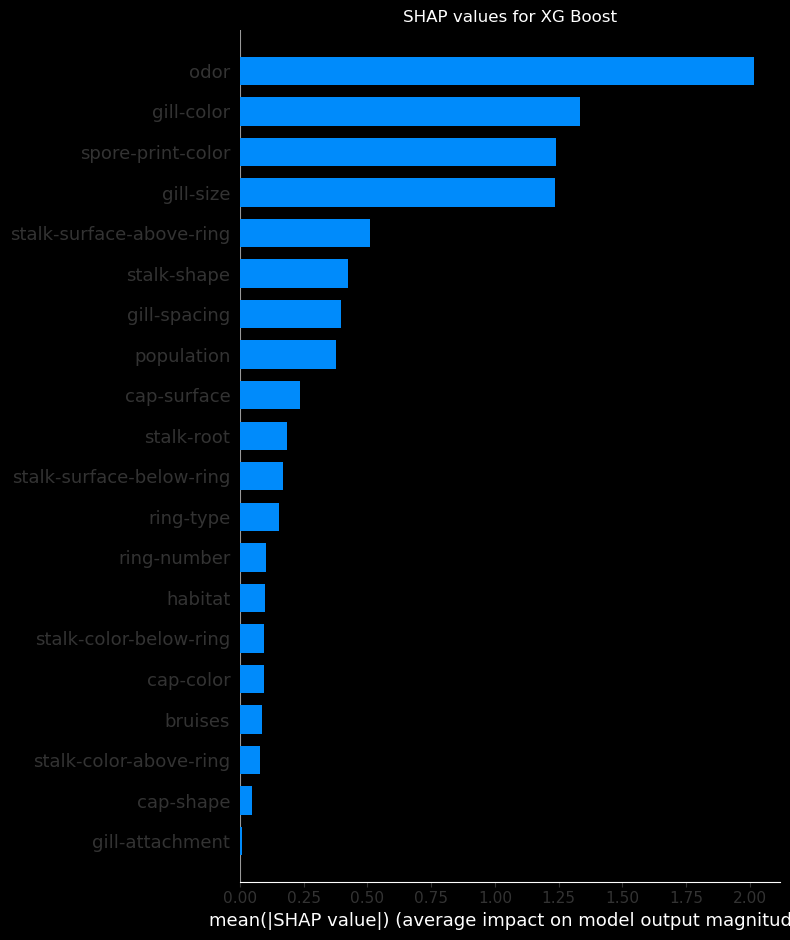

In [38]:
# Analyzing SHAP-value
print(type(x_train))
print(x_train.shape)

print(type(bst))
print(hasattr(bst, 'predict'))

# Summarize background data using shap.sample
background_samples = shap.sample(x_train, 100)
print(type(background_samples))
print(background_samples.shape)

# SHAP Interpretation
explainer_bst = shap.TreeExplainer(bst)
shap_values_bst = explainer_bst.shap_values(x_train)

#explainer_bst = shap.KernelExplainer(bst.predict, background_samples)
#shap_values_bst = explainer_bst.shap_values(x_train)

# Ensure the shapes are as expected
print(f"Background samples shape: {background_samples.shape}")
print(f"SHAP values shape: {np.array(shap_values_bst).shape}")

plt.figure(figsize=(8, 8))
plt.title("SHAP values for XG Boost")
shap.summary_plot(shap_values_bst, x_train, plot_type="bar")
plt.show()

In [46]:
# calculate accuracy, precision and recall for XG Boost
predict_bst= bst.predict(x_test)

cm = confusion_matrix(predict_bst, y_test)
_, fp, fn, tp = cm.ravel()

print("accuracy of XG Boost: {}".format(accuracy_score(predict_bst, y_test)))
print("precision of XG Boost: {}".format(tp/(tp + fp)))
print("recall of XG Boost: {}".format(tp/(tp + fn)))

accuracy of XG Boost: 1.0
precision of XG Boost: 1.0
recall of XG Boost: 1.0


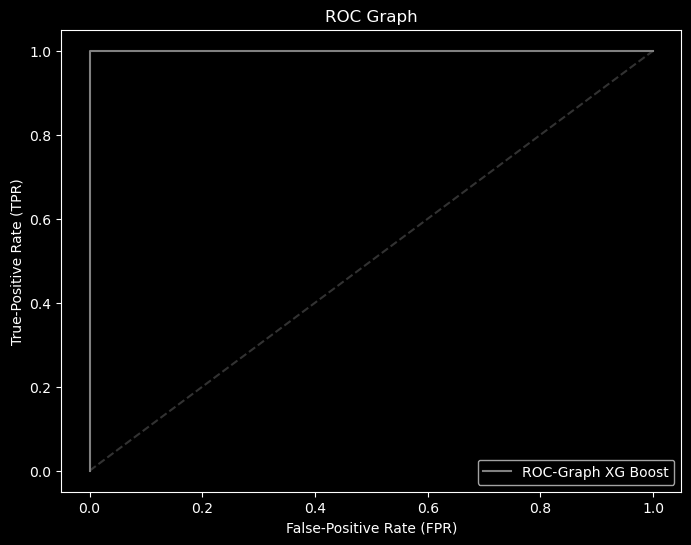

In [47]:
# Graphing the ROC-Graph
plt.figure(figsize=(8,6))
plt.title("ROC Graph")
fpr, tpr, thresholds = metrics.roc_curve(y_test.values, bst.predict_proba(x_test)[:,1:])
plt.plot([0,1],[0,1],ls="--",c="white",alpha=0.2)
plt.plot(fpr,tpr,label="ROC-Graph XG Boost",c="grey")
plt.xlabel("False-Positive Rate (FPR)")
plt.ylabel("True-Positive Rate (TPR)")
plt.legend()
plt.show()

### Bagging-Ensemble

In [48]:
# Building a Model: Bagging-Ensemble
ensemble = VotingClassifier([("knn",KNeighborsClassifier()),("logreg",LogisticRegression()),("random",RandomForestClassifier(criterion="entropy", max_depth=5, min_samples_split=5, random_state=1))], voting='soft')
ensemble.fit(x_train,y_train)

/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


VotingClassifier(estimators=[('knn', KNeighborsClassifier()),
                             ('logreg', LogisticRegression()),
                             ('random',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=5,
                                                     min_samples_split=5,
                                                     random_state=1))],
                 voting='soft')

<class 'pandas.core.frame.DataFrame'>
(5443, 22)
<class 'sklearn.ensemble._voting.VotingClassifier'>
True
<class 'pandas.core.frame.DataFrame'>
(1, 22)


/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


  0%|          | 0/5443 [00:00<?, ?it/s]

/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/Pudzich/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/Pudzich/an

Background samples shape: (1, 22)
SHAP values shape: (5443, 22)


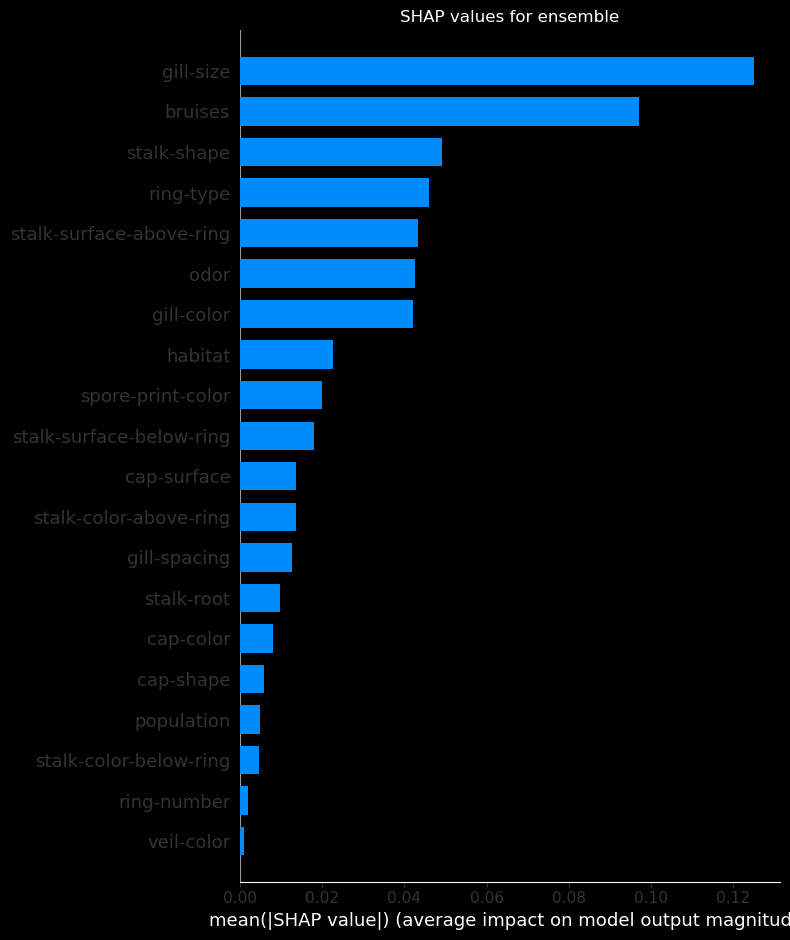

In [42]:
# Analyzing SHAP-value
print(type(x_train))
print(x_train.shape)

print(type(ensemble))
print(hasattr(ensemble, 'predict'))

# Summarize background data using shap.sample
background_samples = shap.sample(x_train, 1)
print(type(background_samples))
print(background_samples.shape)

# SHAP Interpretation
explainer_ensemble = shap.KernelExplainer(ensemble.predict, background_samples)
shap_values_ensemble = explainer_ensemble.shap_values(x_train)

# Ensure the shapes are as expected
print(f"Background samples shape: {background_samples.shape}")
print(f"SHAP values shape: {np.array(shap_values_ensemble).shape}")

plt.figure(figsize=(8, 8))
plt.title("SHAP values for ensemble")
shap.summary_plot(shap_values_ensemble, x_train, plot_type="bar")
plt.show()

In [49]:
# calculate accuracy, precision and recall for ensemble
predict_ensemble= ensemble.predict(x_test)

cm = confusion_matrix(predict_ensemble, y_test)
_, fp, fn, tp = cm.ravel()

print("accuracy of ensemble: {}".format(accuracy_score(predict_ensemble, y_test)))
print("precision of ensemble: {}".format(tp/(tp + fp)))
print("recall of ensemble: {}".format(tp/(tp + fn)))

accuracy of ensemble: 0.9958970533383066
precision of ensemble: 0.9915449654112222
recall of ensemble: 1.0


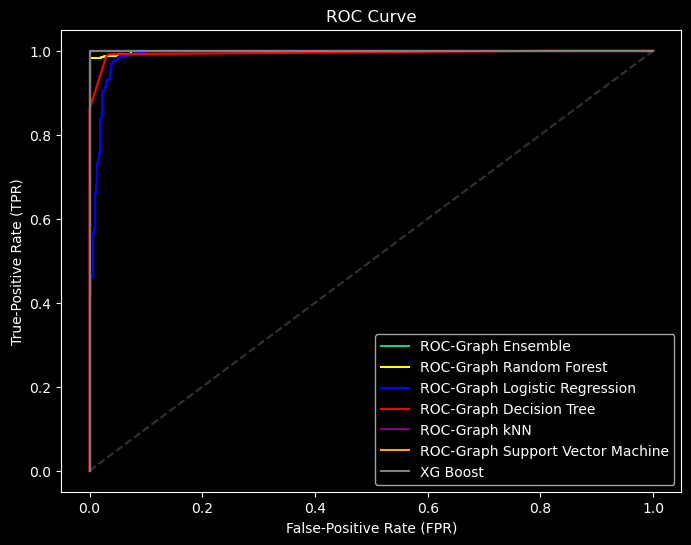

In [50]:
# Graphing all ROC-Curves in one
plt.figure(figsize=(8,6))
plt.title("ROC Curve")
fpr, tpr, thresholds = metrics.roc_curve(y_test.values, ensemble.predict_proba(x_test)[:,1:])
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test.values, random.predict_proba(x_test)[:,1:])
fpr2, tpr2, thresholds2 = metrics.roc_curve(y_test.values, logreg.predict_proba(x_test)[:,1:])
fpr3, tpr3, thresholds3 = metrics.roc_curve(y_test.values, dtc.predict_proba(x_test)[:,1:])
fpr4, tpr4, thresholds4 = metrics.roc_curve(y_test.values, knn.predict_proba(x_test)[:,1:])
fpr5, tpr5, thresholds5 = metrics.roc_curve(y_test.values, svm.predict_proba(x_test)[:,1:])
fpr6, tpr6, thresholds6 = metrics.roc_curve(y_test.values, bst.predict_proba(x_test)[:,1:])
plt.plot([0,1],[0,1],ls="--",c="white",alpha=0.2)
plt.plot(fpr,tpr,label="ROC-Graph Ensemble",c="#1ACC94")
plt.plot(fpr1,tpr1,label="ROC-Graph Random Forest",c="yellow")
plt.plot(fpr2,tpr2,label="ROC-Graph Logistic Regression",c="blue")
plt.plot(fpr3,tpr3,label="ROC-Graph Decision Tree",c="red")
plt.plot(fpr4,tpr4,label="ROC-Graph kNN",c="purple")
plt.plot(fpr5,tpr5,label="ROC-Graph Support Vector Machine",c="orange")
plt.plot(fpr6,tpr6,label="XG Boost",c="grey")
plt.xlabel("False-Positive Rate (FPR)")
plt.ylabel("True-Positive Rate (TPR)")
plt.legend()
plt.show()

In [51]:
# calculate AUROC scores
auroc_dtc = roc_auc_score(y_test, predict_dtc)
auroc_logreg = roc_auc_score(y_test, predict_logreg)
auroc_random = roc_auc_score(y_test, predict_random)
auroc_ensemble = roc_auc_score(y_test, predict_ensemble)
auroc_knn = roc_auc_score(y_test, predict_knn)
auroc_svm = roc_auc_score(y_test, predict_svm)
auroc_bst = roc_auc_score(y_test, predict_bst)

print("AUROC-Score for Decision Tree: {}".format(auroc_dtc))
print("AUROC-Score for Logistic Regression: {}".format(auroc_logreg))
print("AUROC-Score for Random Forest: {}".format(auroc_random))
print("AUROC-Score for Ensemble: {}".format(auroc_ensemble))
print("AUROC-Score for kNN: {}".format(auroc_knn))
print("AUROC-Score for Support Vector Machine: {}".format(auroc_svm))
print("AUROC-Score for XG Boost: {}".format(auroc_bst))

AUROC-Score for Decision Tree: 0.9791058160389444
AUROC-Score for Logistic Regression: 0.9655123149416838
AUROC-Score for Random Forest: 0.9907763259031515
AUROC-Score for Ensemble: 0.9957724827056111
AUROC-Score for kNN: 1.0
AUROC-Score for Support Vector Machine: 0.9985507246376812
AUROC-Score for XG Boost: 1.0
